In [7]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GENConv, GATv2Conv, SSGConv
import numpy as np
from torch_geometric.data import Data
from torch.utils.data import DataLoader
import torch_geometric.utils

from tqdm import tqdm

from sklearn.model_selection import KFold
import pandas as pd
from MatrixVectorizer import MatrixVectorizer


In [8]:
# set global variables
N_SUBJECTS = 167

N_LR_NODES = 160

N_HR_NODES = 268

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

N_LR_NODES_F = int(N_LR_NODES * (N_LR_NODES-1) / 2)
N_HR_NODES_F = int(N_HR_NODES * (N_HR_NODES-1) / 2)

In [9]:
from data_preparation import load_data_tensor

lr_train, lr_test, hr_train = load_data_tensor("dgl-icl")

lr_X_dim1 = torch.load('model_autoencoder/final_embeddings/encode_lr.pt')
lr_X_dim3 = torch.load('model_autoencoder/final_embeddings/encode_lr_3.pt')
hr_X_dim1 = torch.load('model_autoencoder/final_embeddings/encode_hr.pt')
hr_X_dim3 = torch.load('model_autoencoder/final_embeddings/encode_hr_3.pt')
lr_X_dim1_test = torch.load('model_autoencoder/final_embeddings/encode_lr_test.pt')
hr_X_dim3_test = torch.load('model_autoencoder/final_embeddings/encode_lr_test_3.pt')


# lr_X_dim1 = torch.ones((167, 160, 32))
# lr_X_dim3 = torch.ones((167, 160, 32))
# hr_X_dim1 = torch.ones((167, 268, 32))
# hr_X_dim3 = torch.ones((167, 268, 32))
# lr_X_dim1_test = torch.ones((167, 160, 32))
# hr_X_dim3_test = torch.ones((167, 268, 32))


In [10]:
print(lr_X_dim1.shape)
print(lr_X_dim1.shape)



torch.Size([167, 160, 32])
torch.Size([167, 160, 32])


# Model Layers

In [11]:
def generate_steps(num_steps, low=N_LR_NODES, high=N_HR_NODES):
    step_size = (high - low) / (num_steps - 1)
    steps_list = [round(low + step_size * i) for i in range(num_steps)]
    return steps_list

In [12]:
class StackedGCN(nn.Module):
    def __init__(self, n_nodes, channel_ls, dropout):
        super().__init__()
        self.n_nodes = n_nodes
        self.gcn_layers, self.batch_norm_layers = self._init_layers(channel_ls)

        # self.gcn_layers, _ = self._init_layers(channel_ls)
        self.dropout = dropout
        
    
    def forward(self, X, A):
        for i in range(len(self.gcn_layers)):
            gcn = self.gcn_layers[i]
            batch_norm = self.batch_norm_layers[i]
            graph_batch = self._create_batch(X, A)
            
            X = F.sigmoid(gcn(graph_batch.x, graph_batch.edge_index, graph_batch.edge_attr).reshape(*X.shape[:2], -1))
            torch.cuda.empty_cache()
            X = F.dropout(batch_norm(X), self.dropout, training=self.training)
            # X = F.dropout(X, self.dropout, training=self.training)
            torch.cuda.empty_cache()

        return X

    def _init_layers(self, channel_ls):
        layers_ls = []
        batch_norm_ls = []
        for i in range(len(channel_ls) - 1):
            layer = GATv2Conv(channel_ls[i], channel_ls[i], heads=2, edge_dim=1)
            layers_ls.append(layer)
            batch_norm_ls.append(torch_geometric.nn.norm.BatchNorm(self.n_nodes))
        return nn.ModuleList(layers_ls), nn.ModuleList(batch_norm_ls)

    def _create_batch(self, X, A):
        data_list = []
        for x, adj in zip(X, A):
            edge_index = adj.nonzero().t()
            edge_weights = adj[edge_index[0], edge_index[1]]
            edge_index, edge_weights = torch_geometric.utils.add_self_loops(edge_index, edge_weights) # add self connections
            data = Data(x=x, edge_index=edge_index, edge_attr=edge_weights.view(-1, 1))
            data_list.append(data)
        return torch_geometric.data.Batch().from_data_list(data_list)

In [13]:
class AdjacencyStep(nn.Module):
    def __init__(self, old_dim, new_dim, channels_ls, dt=1., alpha=0.9, gamma=0.9, dropout=0.25):
        super().__init__()
        self.dt = dt
        self.alpha = alpha
        self.gamma = gamma
        self.gnn = StackedGCN(old_dim, channels_ls, dropout).to(DEVICE)
        self.dropout = dropout
        # self.dim_changer1 = nn.Parameter(torch.randn((new_dim, 1), device=DEVICE))
        # self.dim_changer2 = nn.Parameter(torch.randn((1, old_dim), device=DEVICE))
        self.dim_changer = nn.Parameter(torch.randn((new_dim, old_dim), device=DEVICE))

        self.A_dim_changer = nn.Parameter(torch.randn((new_dim, old_dim), device=DEVICE))
        # self.A_dim_changer1 = nn.Parameter(torch.randn((new_dim, 1), device=DEVICE))   
        # self.A_dim_changer2 = nn.Parameter(torch.randn((1, old_dim), device=DEVICE))
        self.A_dim_bias = nn.Parameter(torch.randn((new_dim, 1), device=DEVICE))

        self.Z_dim_changer = nn.Parameter(torch.randn((channels_ls[-1], new_dim), device=DEVICE))
        # self.Z_dim_changer1 = nn.Parameter(torch.randn((channels_ls[-1], 1), device=DEVICE))   
        # self.Z_dim_changer2 = nn.Parameter(torch.randn((1, new_dim), device=DEVICE))
        self.Z_dim_bias = nn.Parameter(torch.randn((new_dim, 1), device=DEVICE))

        self.Z_dim_lower = nn.Conv1d(channels_ls[-1], channels_ls[0], kernel_size=1)


        self.forget_gate = nn.Parameter(torch.randn(new_dim, device=DEVICE))
        self.input_gate = nn.Parameter(torch.randn(new_dim, device=DEVICE))

        self.batchnorm_A = torch_geometric.nn.norm.BatchNorm(new_dim)
        self.layernorm_forget_A = torch_geometric.nn.norm.LayerNorm((new_dim, new_dim))
        self.layernorm_input_Z = torch_geometric.nn.norm.LayerNorm((new_dim, new_dim))
        self.batchnorm_X = torch_geometric.nn.norm.BatchNorm(new_dim)
        self.batchnorm_Y = torch_geometric.nn.norm.BatchNorm(new_dim)



    def forward(self, X, Y, A):
        # solve ODEs using simple IMEX scheme
        # dim_changer = self.dim_changer1 @ self.dim_changer2 
        # A_dim_changer = self.A_dim_changer1 @ self.A_dim_changer2
        # Z_dim_changer = self.Z_dim_changer1 @ self.Z_dim_changer2
        dim_changer = self.dim_changer
        A_dim_changer = self.A_dim_changer
        Z_dim_changer = self.Z_dim_changer

        # forget gate from previous adjacency
        f = F.sigmoid(self.forget_gate)
        i = F.sigmoid(self.input_gate)
        forget_A = F.elu(A_dim_changer @ A @ A_dim_changer.T + self.A_dim_bias)
        forget_A = f[:, None] * self.layernorm_forget_A(forget_A)
        # forget_A = f[:, None] * forget_A
        torch.cuda.empty_cache()

    
        # update node features with gcn
        Z = self.gnn(X, A)
        torch.cuda.empty_cache()
        input_Z = F.elu(dim_changer @ Z @ Z_dim_changer + self.Z_dim_bias)
        input_Z = i[:, None] * self.layernorm_input_Z(input_Z)
        # input_Z = i[:, None] * input_Z
        torch.cuda.empty_cache()



        # get new adjacency matrix
        new_A = forget_A + input_Z
        new_A = self.batchnorm_A(new_A)
        new_A = (new_A + torch.transpose(new_A, -1, -2)) / 2
        #new_A = F.relu(custom_activation(new_A))
        new_A = F.tanh(F.relu(new_A))
        # new_A = F.hardtanh(F.hardtanh(new_A, min_val=0), min_val=0)


        torch.cuda.empty_cache()


        # update feature embeiddings
        Z = torch.transpose(self.Z_dim_lower(torch.transpose(Z, -1, -2)), -1, -2)
        Y_temp = Y
        Y = dim_changer @ (Y + self.dt * (Z - self.alpha * Y - self.gamma * X))
        X = dim_changer @ (X + self.dt * Y_temp) 

        X = self.batchnorm_X(X)
        Y = self.batchnorm_Y(Y)   
        torch.cuda.empty_cache()


        Y = F.dropout(Y, self.dropout, training=self.training)
        X = F.dropout(X, self.dropout, training=self.training)

        return X, Y, new_A

def custom_activation(x):
    return (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-5*x))

    

In [14]:
class embedder(torch.nn.Module):
    def __init__(self, in_dim, hidden, out_dim):
        super(embedder, self).__init__()
        self.omega1 = nn.Parameter(torch.randn((hidden, in_dim), device=DEVICE))
        self.beta1 = nn.Parameter(torch.zeros((hidden, 1), device=DEVICE))
        self.omega2 = nn.Parameter(torch.randn((out_dim, hidden), device=DEVICE))
        self.beta2 = nn.Parameter(torch.zeros((out_dim, 1), device=DEVICE))

    def forward(self, A):
        X = F.elu(self.beta1 + self.omega1 @ A)
        X = F.elu(self.beta2 + self.omega2 @ X)
        
        return torch.transpose(X,-1,-2)


In [29]:
class AdjacencyDimChanger(nn.Module):

    def __init__(self, dim_steps, channels_ls, embedding_dims_ls=None):
        super().__init__()

        self.has_embedding_layer = False
        if embedding_dims_ls:
            self.has_embedding_layer = True
            assert len(embedding_dims_ls) == 3, 'Embedding dim list must be exactly 3'
            assert channels_ls[0] == embedding_dims_ls[-1], f'Last embedding dim must match first channel dim. Received {channels_ls[0]} and {embedding_dims_ls[-1]}'
            self.embedder = embedder(embedding_dims_ls[0], embedding_dims_ls[1], embedding_dims_ls[2])

        self.layers = nn.ModuleList([AdjacencyStep(dim_steps[i], dim_steps[i+1], channels_ls) for i in range(len(dim_steps)-1)])
        # self.batchnorms = nn.ModuleList([nn.BatchNorm1d(dim_steps[i+1]) for i in range(len(dim_steps)-1)])
        
    def forward(self, X, Y, A):

        if self.has_embedding_layer:
            X = self.embedder(A)
            Y = X

        adj_ls = [A]
        x, y, adj = X, Y, A
        
        for layer in self.layers:
            x, y, adj = layer(x, y, adj)
            adj_ls.append(adj)
            
        return adj_ls
        

In [16]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True

In [17]:
import numpy as np
import networkx as nx

def eigen_centrality(data):
    # ROI is the number of brain regions (i.e.,35 in our case)
    ROI = 160

    topology_eigen = []

    G = nx.from_numpy_array(np.absolute(data))
    U = G.to_undirected()

    # A = to_2d(data)
    np.fill_diagonal(data, 0)

    # create a graph frL2
    # # compute egeinvector centrality and transform the output to vector
    ec = nx.eigenvector_centrality_numpy(U)
    
    eigenvector_centrality = np.array([ec[g] for g in U])



    topology_eigen.append(eigenvector_centrality)  # 2

    return topology_eigen

def pearson_coor(input, target, epsilon=1e-7):
    vx = input - torch.mean(input, dim=(1, 2))[:, None, None]
    vy = target - torch.mean(target, dim=(1, 2))[:, None, None]
    cost = torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)+epsilon) * torch.sqrt(torch.sum(vy ** 2)+epsilon)+epsilon)
    return cost

def GT_loss(target, predicted):

    # l1_loss
    l1_loss = torch.nn.L1Loss()
    # loss_pix2pix = l1_loss(target, predicted)

    # topological_loss
    target_n = target.detach().cpu().clone().numpy()
    predicted_n = predicted.detach().cpu().clone().numpy()
    torch.cuda.empty_cache()

    topo_loss = []
    

    for i in range(len(target_n)):

        cur_target = target_n[i]
        cur_predicted = predicted_n[i]

        target_t = eigen_centrality(cur_target)
        real_topology = torch.tensor(target_t[0])
        predicted_t = eigen_centrality(cur_predicted)
        fake_topology = torch.tensor(predicted_t[0])
        topo_loss.append(l1_loss(real_topology, fake_topology))

    topo_loss = torch.sum(torch.stack(topo_loss))

    pc_loss = pearson_coor(target, predicted).to(DEVICE)
    torch.cuda.empty_cache()

    # G_loss = loss_pix2pix + (1 - pc_loss) + topo_loss
    G_loss = (1 - pc_loss) + topo_loss


    return G_loss

In [18]:
def loss_calc(adj_ls, opp_adj_ls, alpha=0.75, weights=None):
    total_loss = torch.Tensor([0]).to(DEVICE)
    mse_loss_fn = nn.MSELoss()

    # calculate the loss for the upper traingle of the matrix because thats what we care about
    final_dim = adj_ls[-1].shape[-1]
    upper_tri_idx = torch.triu_indices(final_dim, final_dim, offset=1)
    final_upper_tri_adj = adj_ls[-1][:,upper_tri_idx.unbind()[0], upper_tri_idx.unbind()[1]]
    final_upper_tri_other_adj = opp_adj_ls[0][:,upper_tri_idx.unbind()[0], upper_tri_idx.unbind()[1]]
    final_mse_loss = mse_loss_fn(final_upper_tri_adj, final_upper_tri_other_adj)

    if weights is None:
        n = len(adj_ls[1:-1])
        weights = torch.Tensor([2*(i+1)/(n*(n+1)) for i in range(n)])
    
    # calculate the loss for the remaining intermediate adjacent matrices
    intermediate_mse_loss = torch.Tensor([0]).to(DEVICE)
    for i, (adj, opp_adj) in enumerate(zip(adj_ls[:-1], opp_adj_ls[1:][::-1])):
        intermediate_mse_loss = intermediate_mse_loss + weights[i] * mse_loss_fn(adj, opp_adj)

    total_loss = total_loss + alpha * final_mse_loss + (1-alpha) * intermediate_mse_loss
    # total_loss = total_loss + alpha * final_mse_loss * (1 + intermediate_mse_loss) * (gamma ** 2)
    # total_loss = total_loss + (1-alpha) * intermediate_mse_loss * (beta ** 2)
        

    # gt_loss = torch.Tensor([0]).to(DEVICE)
    # for i, (adj, opp_adj) in enumerate(zip(adj_ls, opp_adj_ls[::-1])):

    #     ### NOTE TEMPORARY MEASURE BECAUSE THEY TAKE IN (BATCHSIZE, xx, xx) shape ####
    #     temp_adj = adj.reshape(1, *adj.shape)
    #     temp_opp_adj = opp_adj.reshape(1, *opp_adj.shape)
    #     ##########################################################
    #     gt_loss = gt_loss + GT_loss(temp_adj, temp_opp_adj)

    # gt_loss = gt_loss / n
        
    return total_loss

def up_loss_fn(up_adj_ls, down_adj_ls,  epoch, a=0.95, b=0.5, c=0.1): #modified
    total_loss = torch.Tensor([0]).to(DEVICE)
    mse_loss_fn = nn.MSELoss()

    # calculate the loss for the upper traingle of the matrix because thats what we care about
    final_dim = up_adj_ls[-1].shape[-1]
    upper_tri_idx = torch.triu_indices(final_dim, final_dim, offset=1)
    final_upper_tri_adj = up_adj_ls[-1][:,upper_tri_idx.unbind()[0], upper_tri_idx.unbind()[1]]
    final_upper_tri_other_adj = down_adj_ls[0][:,upper_tri_idx.unbind()[0], upper_tri_idx.unbind()[1]]
    final_mse_loss = mse_loss_fn(final_upper_tri_adj, final_upper_tri_other_adj)

    n = len(up_adj_ls[:-1])
    weights = torch.Tensor([2*(i+1)/(n*(n+1)) for i in range(n)])
    
    # calculate the loss for the remaining intermediate adjacent matrices
    intermediate_mse_loss = torch.Tensor([0]).to(DEVICE)
    for i, (up_adj, down_adj) in enumerate(zip(up_adj_ls[:-1], down_adj_ls[1:][::-1])):
        intermediate_mse_loss = intermediate_mse_loss + weights[i] * mse_loss_fn(up_adj, down_adj)

    alpha = (1 - np.exp(-c * epoch)) * (a - b) + b #modified

    total_loss = total_loss + alpha * final_mse_loss + (1-alpha) * intermediate_mse_loss #modified
    return total_loss

def down_loss_fn(down_adj_ls, up_adj_ls):
    total_loss = torch.Tensor([0]).to(DEVICE)
    mse_loss_fn = nn.MSELoss()

    n = len(down_adj_ls[:])
    weights = torch.Tensor([1/n for i in range(n)])
    
    # calculate the loss for the remaining intermediate adjacent matrices
    for i, (down_adj, up_adj) in enumerate(zip(down_adj_ls[:], up_adj_ls[::-1])):
        total_loss = total_loss + weights[i] * mse_loss_fn(down_adj, up_adj)

    return total_loss
    
def reconstruction_loss_fn(gt_adj, pred_adj):
    l1_loss_fn = nn.L1Loss()
    return l1_loss_fn(gt_adj, pred_adj)

def end_adj_loss_calc(adj, opp_adj):
    mae_loss_fn = torch.nn.L1Loss()
    n = len(adj)
    upper_tri_idx = torch.triu_indices(n, n, offset=1)
    upper_tri_adj = adj.detach()[upper_tri_idx.unbind()]
    upper_tri_opp_adj = opp_adj.detach()[upper_tri_idx.unbind()]
    mae_loss = mae_loss_fn(upper_tri_adj, upper_tri_opp_adj)
    # temp_adj = adj.reshape(1, *adj.shape)
    # temp_opp_adj = opp_adj.reshape(1, *opp_adj.shape)
    # gt_loss = GT_loss(temp_adj, temp_opp_adj)
    return mae_loss.detach().item()

# Training

In [38]:
import gc

def train(epochs, up_changer, down_changer, trainloader, up_optimizer, down_optimizer, reconstruction_optimizer, completed_epochs=0, loss_log=None):

    if loss_log is None:
        loss_log = {'up': [], 'down': [], 'up_end_mae':[], 'down_end_mae':[]}

    up_changer.train()
    down_changer.train()   

    #epoch_weight = 1
    for epoch in range(epochs):

        up_losses = []
        up_final_mae_ls = []
        down_final_mae_ls = []
        down_losses = []
        reconstruction_losses = []
            
        #if (epoch + 1) % 10 == 0:
        #    epoch_weight = # modified


        for X_lr, Y_lr, adj_lr, X_hr, Y_hr, adj_hr in trainloader:
            gc.collect()
            freeze_model(up_changer)
            unfreeze_model(down_changer)
        
            down_optimizer.zero_grad()

            
            up_adj_ls = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))
            torch.cuda.empty_cache()
            down_adj_ls = down_changer(X_hr.to(DEVICE), Y_hr.to(DEVICE), adj_hr.to(DEVICE))
            torch.cuda.empty_cache()

            down_loss = down_loss_fn(down_adj_ls[1:], up_adj_ls[:-1])
        
            # for printing loss only
            down_final_mae_ls.append(end_adj_loss_calc(down_adj_ls[-1].detach(), up_adj_ls[0].detach()))
            torch.cuda.empty_cache()
            
            # del down_end_adj_gt_loss
            down_loss.backward()
            down_optimizer.step()

            down_losses.append(down_loss.detach().item())
            del down_loss
            gc.collect()
            torch.cuda.empty_cache()

            unfreeze_model(up_changer)
            freeze_model(down_changer)
        
            up_optimizer.zero_grad()

            up_adj_ls = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))
            torch.cuda.empty_cache()
            down_adj_ls = down_changer(X_hr.to(DEVICE), Y_hr.to(DEVICE), adj_hr.to(DEVICE))
            torch.cuda.empty_cache()
        
            up_loss = up_loss_fn(up_adj_ls[1:], down_adj_ls[:-1], epoch=epoch)
            
            up_loss.backward()
            up_optimizer.step()

            up_losses.append(up_loss.detach().item())
            del up_loss
            gc.collect()
            torch.cuda.empty_cache()

            # for printing loss only
            # non_neg = up_adj_ls[-1].detach().cpu()
            # non_neg[non_neg < 0] = 0
            torch.cuda.empty_cache()
            up_final_mae_ls.append(end_adj_loss_calc(up_adj_ls[-1].detach(), down_adj_ls[0].detach()))
            torch.cuda.empty_cache()

            unfreeze_model(up_changer)
            unfreeze_model(down_changer)

            reconstruction_optimizer.zero_grad()

            down_adj_end = down_changer(X_hr.to(DEVICE), Y_hr.to(DEVICE), adj_hr.to(DEVICE))[-1]
            torch.cuda.empty_cache()

            up_adj_end = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), down_adj_ls[-1])[-1]
            torch.cuda.empty_cache()

            reconstruction_loss = reconstruction_loss_fn(up_adj_end, adj_hr.to(DEVICE))
            reconstruction_loss.backward()
            reconstruction_optimizer.step()
            torch.cuda.empty_cache()

        
            reconstruction_losses.append(reconstruction_loss.detach().item())
            del reconstruction_loss
            gc.collect()
            torch.cuda.empty_cache()
        
        epoch_up_loss = np.mean(up_losses)
        epoch_down_loss = np.mean(down_losses)
        epoch_reconstruction_loss = np.mean(reconstruction_losses)
        epoch_up_final_mae = np.mean(up_final_mae_ls)
        epoch_down_final_mae = np.mean(down_final_mae_ls)
        
        loss_log['up'].append(epoch_up_loss)
        loss_log['down'].append(epoch_down_loss)
        loss_log['up_end_mae'].append(epoch_up_final_mae)
        loss_log['down_end_mae'].append(epoch_down_final_mae)

        if epoch % 5 == 0:
            print(f'ep {epoch}: down loss = {epoch_down_loss}, up loss = {epoch_up_loss}, reconst.loss = {epoch_reconstruction_loss}, down adj mae = {epoch_down_final_mae}, up adj mae = {epoch_up_final_mae}')


    return up_changer, down_changer, loss_log


In [53]:
trainloader = DataLoader(list(zip(lr_X_dim1, lr_X_dim3, lr_train, hr_X_dim1, hr_X_dim3, hr_train)), shuffle=True, batch_size=16)
testloader = DataLoader(list(zip(lr_X_dim1_test, lr_X_dim3, lr_test)), shuffle=True, batch_size=32)

dim_steps = generate_steps(num_steps=6)
channels_ls = [32, 64]
embedding_dims_ls_up = [160,16,32]
embedding_dims_ls_down = [268,16,32]

up_changer = AdjacencyDimChanger(dim_steps, channels_ls, embedding_dims_ls_up).to(DEVICE)
down_changer = AdjacencyDimChanger(dim_steps[::-1], channels_ls, embedding_dims_ls_down).to(DEVICE)

up_optimizer = torch.optim.AdamW(up_changer.parameters(), lr=0.0025, betas=(0.5, 0.999))
down_optimizer = torch.optim.AdamW(down_changer.parameters(), lr=0.0025, betas=(0.5, 0.999))
reconstruction_optimizer = torch.optim.AdamW(list(up_changer.parameters()) + list(down_changer.parameters()), lr=0.0025, betas=(0.5, 0.999))

sum(p.numel() for model in [up_changer, down_changer] for p in model.parameters())


3041132

In [54]:
gc.collect()
up_changer, down_changer, loss_log = train(200, up_changer, down_changer, trainloader, up_optimizer, down_optimizer, reconstruction_optimizer, completed_epochs=0, loss_log=None)

  0%|          | 0/11 [00:00<?, ?it/s]

100%|██████████| 11/11 [00:15<00:00,  1.40s/it]


ep 0: down loss = 0.18892769109119067, up loss = 0.16802923516793686, reconst.loss = 0.28040906109593133, down adj mae = 0.2736617353829471, up adj mae = 0.29104575514793396


100%|██████████| 11/11 [00:15<00:00,  1.37s/it]


ep 1: down loss = 0.1590344174341722, up loss = 0.13685104386373, reconst.loss = 0.2515941099687056, down adj mae = 0.24245925789529627, up adj mae = 0.2575872960415753


100%|██████████| 11/11 [00:14<00:00,  1.33s/it]


ep 2: down loss = 0.13696706972338937, up loss = 0.11632468754594977, reconst.loss = 0.2302739078348333, down adj mae = 0.2335025343027982, up adj mae = 0.24240277301181445


100%|██████████| 11/11 [00:14<00:00,  1.29s/it]


ep 3: down loss = 0.11496955427256497, up loss = 0.09442525018345226, reconst.loss = 0.20273822681470352, down adj mae = 0.21737727929245343, up adj mae = 0.21233389594338156


100%|██████████| 11/11 [00:13<00:00,  1.27s/it]


ep 4: down loss = 0.09748313982378352, up loss = 0.07919251783327623, reconst.loss = 0.18500392545353284, down adj mae = 0.21546319127082825, up adj mae = 0.19153094020756808


100%|██████████| 11/11 [00:14<00:00,  1.30s/it]


ep 5: down loss = 0.08162984251976013, up loss = 0.06820137121460655, reconst.loss = 0.17253963920203122, down adj mae = 0.20392308587377722, up adj mae = 0.1848377680236643


100%|██████████| 11/11 [00:14<00:00,  1.29s/it]


ep 6: down loss = 0.06727207214994864, up loss = 0.05917086858641018, reconst.loss = 0.16598835316571323, down adj mae = 0.18954364278099753, up adj mae = 0.1722069802609357


100%|██████████| 11/11 [00:14<00:00,  1.29s/it]


ep 7: down loss = 0.0563989095389843, up loss = 0.05499271405014125, reconst.loss = 0.16595281660556793, down adj mae = 0.18323979865420947, up adj mae = 0.1697580800815062


100%|██████████| 11/11 [00:14<00:00,  1.28s/it]


ep 8: down loss = 0.047450321980498054, up loss = 0.050555349750952286, reconst.loss = 0.16144382682713596, down adj mae = 0.17665649137713693, up adj mae = 0.16844556006518277


100%|██████████| 11/11 [00:14<00:00,  1.31s/it]


ep 9: down loss = 0.04030494527383284, up loss = 0.04706555130806836, reconst.loss = 0.15753772448409686, down adj mae = 0.1694671796126799, up adj mae = 0.16203899681568146


100%|██████████| 11/11 [00:14<00:00,  1.28s/it]


ep 10: down loss = 0.03354058753360401, up loss = 0.04139817573807456, reconst.loss = 0.15229002183133905, down adj mae = 0.16216691651127554, up adj mae = 0.15534928441047668


100%|██████████| 11/11 [00:14<00:00,  1.28s/it]


ep 11: down loss = 0.030077330429445614, up loss = 0.03976032307202166, reconst.loss = 0.151537071574818, down adj mae = 0.1627821150151166, up adj mae = 0.15412105484442276


100%|██████████| 11/11 [00:13<00:00,  1.26s/it]


ep 12: down loss = 0.027081023224375465, up loss = 0.0386722551828081, reconst.loss = 0.1497335908087817, down adj mae = 0.1519351594827392, up adj mae = 0.14857625554908405


100%|██████████| 11/11 [00:14<00:00,  1.28s/it]


ep 13: down loss = 0.024253382770852608, up loss = 0.03661515868522904, reconst.loss = 0.1474902399561622, down adj mae = 0.15129964730956338, up adj mae = 0.14773966507478195


100%|██████████| 11/11 [00:13<00:00,  1.27s/it]


ep 14: down loss = 0.022282115776430477, up loss = 0.036055208945816215, reconst.loss = 0.14565855129198593, down adj mae = 0.15421388366005637, up adj mae = 0.14922804724086414


100%|██████████| 11/11 [00:14<00:00,  1.28s/it]


ep 15: down loss = 0.020765033296563408, up loss = 0.03584767776456746, reconst.loss = 0.14456454461271112, down adj mae = 0.14831599457697434, up adj mae = 0.1478749323974956


100%|██████████| 11/11 [00:13<00:00,  1.24s/it]


ep 16: down loss = 0.019127846610817043, up loss = 0.03352843597531319, reconst.loss = 0.14211456342176956, down adj mae = 0.1448180296204307, up adj mae = 0.14147137918255545


100%|██████████| 11/11 [00:13<00:00,  1.24s/it]


ep 17: down loss = 0.018202788281169804, up loss = 0.033513493835926056, reconst.loss = 0.14120595969937064, down adj mae = 0.1460138816725124, up adj mae = 0.14318111809817227


100%|██████████| 11/11 [00:13<00:00,  1.26s/it]


ep 18: down loss = 0.01761269501664422, up loss = 0.0327677708119154, reconst.loss = 0.14056366004727103, down adj mae = 0.14970569041642276, up adj mae = 0.14324632287025452


100%|██████████| 11/11 [00:13<00:00,  1.23s/it]


ep 19: down loss = 0.017239569940350273, up loss = 0.032612997191873466, reconst.loss = 0.14038634977557443, down adj mae = 0.14414841749451376, up adj mae = 0.14054502140391956


100%|██████████| 11/11 [00:14<00:00,  1.28s/it]


ep 20: down loss = 0.016512967730787666, up loss = 0.032319600439884445, reconst.loss = 0.13943234356966885, down adj mae = 0.14544631947170605, up adj mae = 0.141255109147592


100%|██████████| 11/11 [00:13<00:00,  1.26s/it]


ep 21: down loss = 0.015584323131902651, up loss = 0.032786701382561165, reconst.loss = 0.1383361599662087, down adj mae = 0.14363687553189017, up adj mae = 0.14026435667818243


100%|██████████| 11/11 [00:13<00:00,  1.27s/it]


ep 22: down loss = 0.014853233979506926, up loss = 0.03233605944974856, reconst.loss = 0.13908259570598602, down adj mae = 0.1404147053306753, up adj mae = 0.13768226179209622


100%|██████████| 11/11 [00:13<00:00,  1.25s/it]


ep 23: down loss = 0.014941799793053757, up loss = 0.032493470067327675, reconst.loss = 0.13887834548950195, down adj mae = 0.14419479397210208, up adj mae = 0.1395204649730162


100%|██████████| 11/11 [00:13<00:00,  1.24s/it]


ep 24: down loss = 0.014552458274093542, up loss = 0.03241672112860463, reconst.loss = 0.13861993632533334, down adj mae = 0.14261508665301584, up adj mae = 0.13982462070204996


100%|██████████| 11/11 [00:13<00:00,  1.24s/it]


ep 25: down loss = 0.013756700791418552, up loss = 0.030973748727278275, reconst.loss = 0.13762267882173712, down adj mae = 0.1374657770449465, up adj mae = 0.13402726839889179


100%|██████████| 11/11 [00:13<00:00,  1.22s/it]


ep 26: down loss = 0.01336490794677626, up loss = 0.031471258368004455, reconst.loss = 0.13712397488680753, down adj mae = 0.14061814817515286, up adj mae = 0.13681405918164688


100%|██████████| 11/11 [00:13<00:00,  1.27s/it]


ep 27: down loss = 0.013340209187431768, up loss = 0.03104306130924008, reconst.loss = 0.1371160542423075, down adj mae = 0.1406170752915469, up adj mae = 0.13576652516018262


100%|██████████| 11/11 [00:13<00:00,  1.26s/it]


ep 28: down loss = 0.012998655353757467, up loss = 0.03098909929394722, reconst.loss = 0.1371820325201208, down adj mae = 0.14192483641884543, up adj mae = 0.13709778541868384


100%|██████████| 11/11 [00:14<00:00,  1.29s/it]


ep 29: down loss = 0.012570439245213161, up loss = 0.03171995807100426, reconst.loss = 0.13712751052596353, down adj mae = 0.13924387097358704, up adj mae = 0.1365919980135831


100%|██████████| 11/11 [00:13<00:00,  1.24s/it]


ep 30: down loss = 0.012382947162471035, up loss = 0.03137819485908205, reconst.loss = 0.136358304457231, down adj mae = 0.14026505567810751, up adj mae = 0.1372650997205214


100%|██████████| 11/11 [00:14<00:00,  1.29s/it]


ep 31: down loss = 0.011980065059932795, up loss = 0.030659168281338432, reconst.loss = 0.1356422481211749, down adj mae = 0.1383988532153043, up adj mae = 0.13650057397105478


100%|██████████| 11/11 [00:13<00:00,  1.25s/it]


ep 32: down loss = 0.011847239749675447, up loss = 0.030825633386319332, reconst.loss = 0.13599767874587665, down adj mae = 0.1372256800532341, up adj mae = 0.13437541980635037


100%|██████████| 11/11 [00:14<00:00,  1.28s/it]


ep 33: down loss = 0.011680029586634853, up loss = 0.030739311636848884, reconst.loss = 0.13627113808285107, down adj mae = 0.13622622869231485, up adj mae = 0.13445023244077509


100%|██████████| 11/11 [00:13<00:00,  1.27s/it]


ep 34: down loss = 0.011696761304681952, up loss = 0.030746776779944248, reconst.loss = 0.13596957921981812, down adj mae = 0.13958364860578018, up adj mae = 0.13742526959289203


100%|██████████| 11/11 [00:13<00:00,  1.27s/it]


ep 35: down loss = 0.011442910033193502, up loss = 0.030606439675797115, reconst.loss = 0.13568038696592505, down adj mae = 0.13748330690644003, up adj mae = 0.1379364701834592


100%|██████████| 11/11 [00:13<00:00,  1.25s/it]


ep 36: down loss = 0.011053215204314753, up loss = 0.030522074550390244, reconst.loss = 0.1345494484359568, down adj mae = 0.13929116590456528, up adj mae = 0.1361022103916515


100%|██████████| 11/11 [00:13<00:00,  1.22s/it]


ep 37: down loss = 0.011008915152739395, up loss = 0.0302024417641488, reconst.loss = 0.1348382221026854, down adj mae = 0.13984921100464734, up adj mae = 0.13549105552109805


100%|██████████| 11/11 [00:13<00:00,  1.25s/it]


ep 38: down loss = 0.010708469812842932, up loss = 0.030152610249140045, reconst.loss = 0.13480457121675665, down adj mae = 0.134284376420758, up adj mae = 0.1338013546033339


100%|██████████| 11/11 [00:13<00:00,  1.24s/it]


ep 39: down loss = 0.010546408000994812, up loss = 0.030048942701383072, reconst.loss = 0.134281570261175, down adj mae = 0.13922638378360055, up adj mae = 0.13644119826230136


100%|██████████| 11/11 [00:13<00:00,  1.23s/it]


ep 40: down loss = 0.01044127353551713, up loss = 0.030131954191760582, reconst.loss = 0.13475877859375693, down adj mae = 0.13692172413522546, up adj mae = 0.1350847834890539


100%|██████████| 11/11 [00:13<00:00,  1.26s/it]


ep 41: down loss = 0.010142004964026537, up loss = 0.029513798823410816, reconst.loss = 0.1337624950842424, down adj mae = 0.13759948177771134, up adj mae = 0.1354744556275281


100%|██████████| 11/11 [00:13<00:00,  1.23s/it]


ep 42: down loss = 0.010358796624297445, up loss = 0.030115314505316994, reconst.loss = 0.13506990671157837, down adj mae = 0.1369572620500218, up adj mae = 0.13357262110168283


100%|██████████| 11/11 [00:13<00:00,  1.26s/it]


ep 43: down loss = 0.010070777921514078, up loss = 0.029510670934211124, reconst.loss = 0.13410816002975812, down adj mae = 0.1391911032524976, up adj mae = 0.1343600479039279


100%|██████████| 11/11 [00:13<00:00,  1.25s/it]


ep 44: down loss = 0.01014986735853282, up loss = 0.02967824126509103, reconst.loss = 0.13411089100620963, down adj mae = 0.13672712580724197, up adj mae = 0.13276792859489267


100%|██████████| 11/11 [00:13<00:00,  1.24s/it]


ep 45: down loss = 0.010086028328673407, up loss = 0.029117941517721523, reconst.loss = 0.13332371007312427, down adj mae = 0.13553635776042938, up adj mae = 0.1312527988444675


100%|██████████| 11/11 [00:13<00:00,  1.25s/it]


ep 46: down loss = 0.010238422419537197, up loss = 0.029622842811725357, reconst.loss = 0.13448720086704602, down adj mae = 0.14052210341800342, up adj mae = 0.13674440099434418


100%|██████████| 11/11 [00:13<00:00,  1.26s/it]


ep 47: down loss = 0.009906600483439186, up loss = 0.02933419580486688, reconst.loss = 0.13382817804813385, down adj mae = 0.13649387251247058, up adj mae = 0.13368576561862772


100%|██████████| 11/11 [00:14<00:00,  1.29s/it]


ep 48: down loss = 0.009805967269295996, up loss = 0.028917858038436283, reconst.loss = 0.13330377502874893, down adj mae = 0.1344621628522873, up adj mae = 0.132310996001417


100%|██████████| 11/11 [00:13<00:00,  1.24s/it]


ep 49: down loss = 0.00974928443743424, up loss = 0.029109383848580448, reconst.loss = 0.1329671564427289, down adj mae = 0.1356415403160182, up adj mae = 0.13279750469056043


100%|██████████| 11/11 [00:13<00:00,  1.23s/it]


ep 50: down loss = 0.009773140349848703, up loss = 0.029041105542670597, reconst.loss = 0.1331912035291845, down adj mae = 0.13615463809533554, up adj mae = 0.13142553581432861


100%|██████████| 11/11 [00:13<00:00,  1.22s/it]


ep 51: down loss = 0.009734151969579134, up loss = 0.02891921370544217, reconst.loss = 0.1333649144931273, down adj mae = 0.13624592802741312, up adj mae = 0.1335518861358816


100%|██████████| 11/11 [00:13<00:00,  1.26s/it]


ep 52: down loss = 0.009742571972310543, up loss = 0.029000597243959255, reconst.loss = 0.1332106346433813, down adj mae = 0.1372617076743733, up adj mae = 0.1344173178076744


100%|██████████| 11/11 [00:13<00:00,  1.26s/it]


ep 53: down loss = 0.009638030335984447, up loss = 0.02900177849964662, reconst.loss = 0.13342259688810867, down adj mae = 0.13591914285313, up adj mae = 0.13201156597245822


100%|██████████| 11/11 [00:13<00:00,  1.24s/it]


ep 54: down loss = 0.009553150104528124, up loss = 0.02839326672255993, reconst.loss = 0.13230515203692697, down adj mae = 0.13687276975675064, up adj mae = 0.1331358253955841


100%|██████████| 11/11 [00:13<00:00,  1.25s/it]


ep 55: down loss = 0.00958609479394826, up loss = 0.02872102250429717, reconst.loss = 0.1330771337855946, down adj mae = 0.13676851445978339, up adj mae = 0.13365956260399384


100%|██████████| 11/11 [00:13<00:00,  1.25s/it]


ep 56: down loss = 0.009684121574867855, up loss = 0.029076769440011543, reconst.loss = 0.13369885222478348, down adj mae = 0.13911403851075607, up adj mae = 0.1313038251616738


100%|██████████| 11/11 [00:13<00:00,  1.25s/it]


ep 57: down loss = 0.00964837758378549, up loss = 0.028655132786794144, reconst.loss = 0.13345820118080487, down adj mae = 0.13713525912978433, up adj mae = 0.13303522901101547


100%|██████████| 11/11 [00:13<00:00,  1.24s/it]


ep 58: down loss = 0.009661883539096876, up loss = 0.028491629456931896, reconst.loss = 0.13279141892086377, down adj mae = 0.13360574570569125, up adj mae = 0.13134497200900858


100%|██████████| 11/11 [00:13<00:00,  1.25s/it]


ep 59: down loss = 0.009538415396078066, up loss = 0.02830561436712742, reconst.loss = 0.13242554664611816, down adj mae = 0.13423041999340057, up adj mae = 0.13106385686180808


100%|██████████| 11/11 [00:13<00:00,  1.26s/it]


ep 60: down loss = 0.00982579571956938, up loss = 0.028790641406720333, reconst.loss = 0.13363275744698264, down adj mae = 0.13624184985052457, up adj mae = 0.13348520276221362


100%|██████████| 11/11 [00:13<00:00,  1.26s/it]


ep 61: down loss = 0.01015056771310893, up loss = 0.02799485759301619, reconst.loss = 0.13281972299922595, down adj mae = 0.13479988683353772, up adj mae = 0.1321076683022759


100%|██████████| 11/11 [00:13<00:00,  1.24s/it]


ep 62: down loss = 0.009974731809713623, up loss = 0.027913693169301205, reconst.loss = 0.13182925974780862, down adj mae = 0.137145611372861, up adj mae = 0.13206829875707626


100%|██████████| 11/11 [00:13<00:00,  1.22s/it]


ep 63: down loss = 0.009707615880126303, up loss = 0.028098901903087444, reconst.loss = 0.13231145387346094, down adj mae = 0.13291517170992764, up adj mae = 0.13136822391640057


100%|██████████| 11/11 [00:13<00:00,  1.24s/it]


ep 64: down loss = 0.009750525721094826, up loss = 0.02768016623502428, reconst.loss = 0.13214755058288574, down adj mae = 0.1352772279219194, up adj mae = 0.13267014920711517


100%|██████████| 11/11 [00:13<00:00,  1.23s/it]


ep 65: down loss = 0.009782187809998339, up loss = 0.027953227304599503, reconst.loss = 0.13259802487763492, down adj mae = 0.1359333951364864, up adj mae = 0.1327052576975389


100%|██████████| 11/11 [00:13<00:00,  1.23s/it]


ep 66: down loss = 0.009665135548196056, up loss = 0.02804837240414186, reconst.loss = 0.13268145715648477, down adj mae = 0.13453382118181748, up adj mae = 0.13126148689876904


100%|██████████| 11/11 [00:13<00:00,  1.25s/it]


ep 67: down loss = 0.009528343650427732, up loss = 0.027754368768496948, reconst.loss = 0.13242225484414535, down adj mae = 0.13475540686737408, up adj mae = 0.13155232234434647


100%|██████████| 11/11 [00:13<00:00,  1.22s/it]


ep 68: down loss = 0.009530839086933569, up loss = 0.02759292924946005, reconst.loss = 0.1322570795362646, down adj mae = 0.13564442910931326, up adj mae = 0.13049784370444037


100%|██████████| 11/11 [00:13<00:00,  1.24s/it]


ep 69: down loss = 0.009608429517935623, up loss = 0.027718619866804642, reconst.loss = 0.1320031244646419, down adj mae = 0.1361266239122911, up adj mae = 0.1314642388712276


100%|██████████| 11/11 [00:13<00:00,  1.22s/it]


ep 70: down loss = 0.009425070221451197, up loss = 0.027603114701130173, reconst.loss = 0.13232566009868274, down adj mae = 0.1360305195504969, up adj mae = 0.13173377513885498


100%|██████████| 11/11 [00:13<00:00,  1.22s/it]


ep 71: down loss = 0.009602031331848015, up loss = 0.02743021043186838, reconst.loss = 0.13225384124300696, down adj mae = 0.13456392830068414, up adj mae = 0.13005440004847266


100%|██████████| 11/11 [00:13<00:00,  1.22s/it]


ep 72: down loss = 0.009692435999485579, up loss = 0.02721947550096295, reconst.loss = 0.13173008439215747, down adj mae = 0.13480382480404593, up adj mae = 0.1302784965796904


100%|██████████| 11/11 [00:13<00:00,  1.22s/it]


ep 73: down loss = 0.009628766978328878, up loss = 0.02701327797364105, reconst.loss = 0.13157453794371, down adj mae = 0.1329550566998395, up adj mae = 0.12889504500410773


100%|██████████| 11/11 [00:13<00:00,  1.24s/it]


ep 74: down loss = 0.009678481824018738, up loss = 0.027047391642223705, reconst.loss = 0.13157639584758066, down adj mae = 0.13277387551286005, up adj mae = 0.12585345926609906


100%|██████████| 11/11 [00:13<00:00,  1.26s/it]


ep 75: down loss = 0.009649055755951187, up loss = 0.02726172621954571, reconst.loss = 0.13175726478750055, down adj mae = 0.13293997740203684, up adj mae = 0.1275725303725763


100%|██████████| 11/11 [00:13<00:00,  1.26s/it]


ep 76: down loss = 0.009859380566261032, up loss = 0.02741003171964125, reconst.loss = 0.13242599232630295, down adj mae = 0.13257480751384387, up adj mae = 0.12918041240085254


100%|██████████| 11/11 [00:13<00:00,  1.22s/it]


ep 77: down loss = 0.00971054175699299, up loss = 0.026946842839772053, reconst.loss = 0.13170341199094598, down adj mae = 0.1331022408875552, up adj mae = 0.12854093448682266


100%|██████████| 11/11 [00:13<00:00,  1.24s/it]


ep 78: down loss = 0.009635989977554842, up loss = 0.026733493093739857, reconst.loss = 0.13137731904333289, down adj mae = 0.13502417775717648, up adj mae = 0.12813204526901245


100%|██████████| 11/11 [00:13<00:00,  1.20s/it]


ep 79: down loss = 0.009771982885219833, up loss = 0.026741251349449158, reconst.loss = 0.131331514228474, down adj mae = 0.13668609342791818, up adj mae = 0.130613043226979


100%|██████████| 11/11 [00:13<00:00,  1.25s/it]


ep 80: down loss = 0.009650413962927732, up loss = 0.027134823189540344, reconst.loss = 0.13263599980961194, down adj mae = 0.13352929733016275, up adj mae = 0.1297942501577464


100%|██████████| 11/11 [00:13<00:00,  1.24s/it]


ep 81: down loss = 0.009790580042383888, up loss = 0.026657024229114704, reconst.loss = 0.1317782374945554, down adj mae = 0.1335758553309874, up adj mae = 0.12769446047869595


100%|██████████| 11/11 [00:13<00:00,  1.22s/it]


ep 82: down loss = 0.009713218039409681, up loss = 0.026489642533389004, reconst.loss = 0.13141342997550964, down adj mae = 0.13280819153243845, up adj mae = 0.12741967832500284


100%|██████████| 11/11 [00:13<00:00,  1.23s/it]


ep 83: down loss = 0.00975933527065949, up loss = 0.02617648768831383, reconst.loss = 0.1306588419459083, down adj mae = 0.13450384614142505, up adj mae = 0.12636074017394672


100%|██████████| 11/11 [00:13<00:00,  1.22s/it]


ep 84: down loss = 0.009792754087935795, up loss = 0.026099953800439835, reconst.loss = 0.13064428080211987, down adj mae = 0.13219923729246313, up adj mae = 0.12786949155005542


100%|██████████| 11/11 [00:13<00:00,  1.24s/it]


ep 85: down loss = 0.009971906007690863, up loss = 0.02653388458896767, reconst.loss = 0.13179109584201465, down adj mae = 0.13321165875955063, up adj mae = 0.12749192186377264


100%|██████████| 11/11 [00:13<00:00,  1.25s/it]


ep 86: down loss = 0.009791461242870851, up loss = 0.02583028714765202, reconst.loss = 0.1309174976565621, down adj mae = 0.1353411701592532, up adj mae = 0.1269301636652513


100%|██████████| 11/11 [00:13<00:00,  1.26s/it]


ep 87: down loss = 0.009890901432795958, up loss = 0.026102461090142078, reconst.loss = 0.13162051886320114, down adj mae = 0.1340469094839963, up adj mae = 0.1285069395195354


100%|██████████| 11/11 [00:13<00:00,  1.22s/it]


ep 88: down loss = 0.009797704914076761, up loss = 0.025683022358200767, reconst.loss = 0.13081299581310965, down adj mae = 0.13370405002073807, up adj mae = 0.12581338056109168


100%|██████████| 11/11 [00:13<00:00,  1.23s/it]


ep 89: down loss = 0.009836177934299816, up loss = 0.02577277950265191, reconst.loss = 0.1308114786039699, down adj mae = 0.13704841990362515, up adj mae = 0.12793902985074304


100%|██████████| 11/11 [00:13<00:00,  1.25s/it]


ep 90: down loss = 0.009815644049509005, up loss = 0.02551288614896211, reconst.loss = 0.13054802742871371, down adj mae = 0.13224796612154355, up adj mae = 0.12453585118055344


100%|██████████| 11/11 [00:13<00:00,  1.22s/it]


ep 91: down loss = 0.009982252832163464, up loss = 0.025702693584290417, reconst.loss = 0.13133360648697073, down adj mae = 0.1345741247588938, up adj mae = 0.125324892049486


100%|██████████| 11/11 [00:13<00:00,  1.24s/it]


ep 92: down loss = 0.009900096888569269, up loss = 0.025596498427065937, reconst.loss = 0.13121041520075363, down adj mae = 0.13351305370981043, up adj mae = 0.12530085308985275


100%|██████████| 11/11 [00:13<00:00,  1.22s/it]


ep 93: down loss = 0.010031429881399328, up loss = 0.025613856755874374, reconst.loss = 0.13136501678011633, down adj mae = 0.13485691357742657, up adj mae = 0.12528604065830057


100%|██████████| 11/11 [00:13<00:00,  1.22s/it]


ep 94: down loss = 0.009960950521582907, up loss = 0.025606759908524426, reconst.loss = 0.1319579089229757, down adj mae = 0.1337481371381066, up adj mae = 0.126150444149971


100%|██████████| 11/11 [00:13<00:00,  1.25s/it]


ep 95: down loss = 0.009867908179082653, up loss = 0.02512328936295076, reconst.loss = 0.1302894949913025, down adj mae = 0.13045303388075394, up adj mae = 0.12307115779681639


100%|██████████| 11/11 [00:13<00:00,  1.21s/it]


ep 96: down loss = 0.009905045090073889, up loss = 0.02505085989832878, reconst.loss = 0.13053303550590167, down adj mae = 0.13537335260347885, up adj mae = 0.12473987923427061


100%|██████████| 11/11 [00:13<00:00,  1.23s/it]


ep 97: down loss = 0.009875065477734262, up loss = 0.02510806630280885, reconst.loss = 0.13067816536534915, down adj mae = 0.13240291042761368, up adj mae = 0.12345565652305429


100%|██████████| 11/11 [00:13<00:00,  1.23s/it]


ep 98: down loss = 0.009895132600583813, up loss = 0.025218260389837353, reconst.loss = 0.13084432956847278, down adj mae = 0.13644940947944467, up adj mae = 0.12716067175973544


100%|██████████| 11/11 [00:13<00:00,  1.26s/it]


ep 99: down loss = 0.009926898150958798, up loss = 0.024804380976340988, reconst.loss = 0.13050601292740216, down adj mae = 0.13296248425136914, up adj mae = 0.12283065711910074


100%|██████████| 11/11 [00:13<00:00,  1.26s/it]


ep 100: down loss = 0.009816870516674086, up loss = 0.024633313783190468, reconst.loss = 0.12974826517430219, down adj mae = 0.13067340579899875, up adj mae = 0.12163991074670445


100%|██████████| 11/11 [00:13<00:00,  1.24s/it]


ep 101: down loss = 0.009929598224433985, up loss = 0.02511359988288446, reconst.loss = 0.13105423545295541, down adj mae = 0.1332412978464907, up adj mae = 0.12335611473430287


100%|██████████| 11/11 [00:13<00:00,  1.22s/it]


ep 102: down loss = 0.009910524907437239, up loss = 0.024774475192481823, reconst.loss = 0.13038160651922226, down adj mae = 0.13390280306339264, up adj mae = 0.12384487417611209


100%|██████████| 11/11 [00:13<00:00,  1.24s/it]


ep 103: down loss = 0.00995447901500897, up loss = 0.024877931414680046, reconst.loss = 0.13104674355550247, down adj mae = 0.1337976184758273, up adj mae = 0.12344396182081917


100%|██████████| 11/11 [00:13<00:00,  1.24s/it]


ep 104: down loss = 0.00998392142355442, up loss = 0.024744794619354336, reconst.loss = 0.13083136623555963, down adj mae = 0.13348353925076398, up adj mae = 0.122044100002809


100%|██████████| 11/11 [00:13<00:00,  1.24s/it]


ep 105: down loss = 0.010090213861655106, up loss = 0.024391320449384777, reconst.loss = 0.13018291646784003, down adj mae = 0.13242792134935205, up adj mae = 0.12143946913155643


100%|██████████| 11/11 [00:13<00:00,  1.22s/it]


ep 106: down loss = 0.010108212347735058, up loss = 0.02473169616000219, reconst.loss = 0.13076910986141724, down adj mae = 0.1309076283465732, up adj mae = 0.12109906361861662


100%|██████████| 11/11 [00:13<00:00,  1.26s/it]


ep 107: down loss = 0.010285454632883722, up loss = 0.025077929212288422, reconst.loss = 0.13143980909477582, down adj mae = 0.13703726096586746, up adj mae = 0.12490352446382696


100%|██████████| 11/11 [00:13<00:00,  1.24s/it]


ep 108: down loss = 0.010182898576286707, up loss = 0.024603708223863083, reconst.loss = 0.13052219152450562, down adj mae = 0.133233135396784, up adj mae = 0.11995101245966824


100%|██████████| 11/11 [00:13<00:00,  1.24s/it]


ep 109: down loss = 0.010103561407463118, up loss = 0.02430510859597813, reconst.loss = 0.12991721318526703, down adj mae = 0.13049485331231897, up adj mae = 0.11874171143228357


100%|██████████| 11/11 [00:13<00:00,  1.23s/it]


ep 110: down loss = 0.010190674696456303, up loss = 0.02424211563034491, reconst.loss = 0.13008833608844064, down adj mae = 0.13187784295190463, up adj mae = 0.12040287933566353


100%|██████████| 11/11 [00:13<00:00,  1.21s/it]


ep 111: down loss = 0.010089741511778398, up loss = 0.024148723449219357, reconst.loss = 0.1297998990524899, down adj mae = 0.13417600366202267, up adj mae = 0.12156910449266434


100%|██████████| 11/11 [00:13<00:00,  1.25s/it]


ep 112: down loss = 0.010335460305213928, up loss = 0.024614020843397488, reconst.loss = 0.1313839934088967, down adj mae = 0.13528720086271112, up adj mae = 0.12260988219217821


100%|██████████| 11/11 [00:13<00:00,  1.24s/it]


ep 113: down loss = 0.010197358713908629, up loss = 0.02384230816228823, reconst.loss = 0.12997486713257703, down adj mae = 0.13302664932879535, up adj mae = 0.11973320083184676


100%|██████████| 11/11 [00:13<00:00,  1.22s/it]


ep 114: down loss = 0.010354611175981436, up loss = 0.023900515992533077, reconst.loss = 0.13030634143135764, down adj mae = 0.13264411213723096, up adj mae = 0.11965958435427058


100%|██████████| 11/11 [00:13<00:00,  1.21s/it]


ep 115: down loss = 0.010207145136188377, up loss = 0.023944009095430374, reconst.loss = 0.13036210157654501, down adj mae = 0.1303165243430571, up adj mae = 0.11840555613691156


100%|██████████| 11/11 [00:13<00:00,  1.23s/it]


ep 116: down loss = 0.010276238942010836, up loss = 0.02390566806901585, reconst.loss = 0.1304529905319214, down adj mae = 0.1338070515881885, up adj mae = 0.12115522880445827


100%|██████████| 11/11 [00:13<00:00,  1.21s/it]


ep 117: down loss = 0.010446474633433601, up loss = 0.023649475621906193, reconst.loss = 0.12980414994738318, down adj mae = 0.13267944075844504, up adj mae = 0.12106226791035045


100%|██████████| 11/11 [00:13<00:00,  1.23s/it]


ep 118: down loss = 0.010426747358658096, up loss = 0.024006071415814487, reconst.loss = 0.13059401444413446, down adj mae = 0.1309757950631055, up adj mae = 0.11793358420783823


100%|██████████| 11/11 [00:13<00:00,  1.24s/it]


ep 119: down loss = 0.010417150248858061, up loss = 0.02361248890784654, reconst.loss = 0.1301394213329662, down adj mae = 0.13387861170551993, up adj mae = 0.1210183860226111


100%|██████████| 11/11 [00:13<00:00,  1.21s/it]


ep 120: down loss = 0.010479326698590408, up loss = 0.023555391214110634, reconst.loss = 0.1303908716548573, down adj mae = 0.1337461986325004, up adj mae = 0.12076744843613017


100%|██████████| 11/11 [00:13<00:00,  1.22s/it]


ep 121: down loss = 0.010488736612552946, up loss = 0.02350559322671457, reconst.loss = 0.1301356784322045, down adj mae = 0.13280578634955667, up adj mae = 0.1187843768434091


100%|██████████| 11/11 [00:13<00:00,  1.24s/it]


ep 122: down loss = 0.01052809718318961, up loss = 0.02339232594452121, reconst.loss = 0.13016052476384424, down adj mae = 0.13167145983739334, up adj mae = 0.11736539073965767


100%|██████████| 11/11 [00:13<00:00,  1.24s/it]


ep 123: down loss = 0.01056587238880721, up loss = 0.02338360995054245, reconst.loss = 0.13012706217440692, down adj mae = 0.13366948880932547, up adj mae = 0.1178904189304872


100%|██████████| 11/11 [00:13<00:00,  1.25s/it]


ep 124: down loss = 0.010605332187630913, up loss = 0.023356242782690308, reconst.loss = 0.1300563785162839, down adj mae = 0.13120919330553574, up adj mae = 0.1166908937421712


100%|██████████| 11/11 [00:13<00:00,  1.19s/it]


ep 125: down loss = 0.01062816787849773, up loss = 0.023316275836391884, reconst.loss = 0.13013663346117194, down adj mae = 0.13188799267465418, up adj mae = 0.11733166873455048


100%|██████████| 11/11 [00:13<00:00,  1.24s/it]


ep 126: down loss = 0.010642156343568455, up loss = 0.023166276514530182, reconst.loss = 0.12994737516749988, down adj mae = 0.1331094286658547, up adj mae = 0.11743213778192346


100%|██████████| 11/11 [00:13<00:00,  1.24s/it]


ep 127: down loss = 0.010813484053042803, up loss = 0.023078275675123387, reconst.loss = 0.129841955547983, down adj mae = 0.13209892267530615, up adj mae = 0.11748947745019739


100%|██████████| 11/11 [00:13<00:00,  1.23s/it]


ep 128: down loss = 0.010851923291656103, up loss = 0.023174633864652027, reconst.loss = 0.13027933646332135, down adj mae = 0.13319485160437497, up adj mae = 0.11805986816232855


100%|██████████| 11/11 [00:13<00:00,  1.21s/it]


ep 129: down loss = 0.010900762863457203, up loss = 0.022978752682154827, reconst.loss = 0.1295758600939404, down adj mae = 0.1319082189689983, up adj mae = 0.1162147664211013


100%|██████████| 11/11 [00:13<00:00,  1.25s/it]


ep 130: down loss = 0.010907663963735104, up loss = 0.02303942817855965, reconst.loss = 0.13044023513793945, down adj mae = 0.13393745639107443, up adj mae = 0.11830865930427205


100%|██████████| 11/11 [00:13<00:00,  1.22s/it]


ep 131: down loss = 0.01088890941305594, up loss = 0.02291371961208907, reconst.loss = 0.13007360696792603, down adj mae = 0.13266999409957367, up adj mae = 0.11620025878602808


100%|██████████| 11/11 [00:13<00:00,  1.21s/it]


ep 132: down loss = 0.010961646044796164, up loss = 0.022865041921084576, reconst.loss = 0.13034827600825916, down adj mae = 0.1325873393904079, up adj mae = 0.1158325888893821


100%|██████████| 11/11 [00:13<00:00,  1.22s/it]


ep 133: down loss = 0.010963212444700977, up loss = 0.022515546530485153, reconst.loss = 0.12940202924338254, down adj mae = 0.13009813224727457, up adj mae = 0.1137488613074476


100%|██████████| 11/11 [00:13<00:00,  1.24s/it]


ep 134: down loss = 0.01110342534428293, up loss = 0.022843044251203537, reconst.loss = 0.13054591010917316, down adj mae = 0.13330549949949438, up adj mae = 0.11549380760301244


100%|██████████| 11/11 [00:13<00:00,  1.22s/it]


ep 135: down loss = 0.011092917401004921, up loss = 0.022617465393109756, reconst.loss = 0.13021701709790665, down adj mae = 0.13130594112656332, up adj mae = 0.11442444405772469


100%|██████████| 11/11 [00:13<00:00,  1.24s/it]


ep 136: down loss = 0.011098201979290356, up loss = 0.02232714742422104, reconst.loss = 0.13011834973638708, down adj mae = 0.1340578239072453, up adj mae = 0.11561400172385303


100%|██████████| 11/11 [00:13<00:00,  1.21s/it]


ep 137: down loss = 0.011115882376378233, up loss = 0.02238534763455391, reconst.loss = 0.13014664907347073, down adj mae = 0.13312207162380219, up adj mae = 0.11486218598755923


100%|██████████| 11/11 [00:13<00:00,  1.20s/it]


ep 138: down loss = 0.011102968488227238, up loss = 0.022195502438328484, reconst.loss = 0.12977950004014102, down adj mae = 0.13361831957643683, up adj mae = 0.1147108247334307


100%|██████████| 11/11 [00:13<00:00,  1.24s/it]


ep 139: down loss = 0.011149281551214781, up loss = 0.02224406989460642, reconst.loss = 0.12998306954448874, down adj mae = 0.13172012161124835, up adj mae = 0.11570969359441237


100%|██████████| 11/11 [00:13<00:00,  1.26s/it]


ep 140: down loss = 0.011116505007852207, up loss = 0.022025433961640705, reconst.loss = 0.12975181503729386, down adj mae = 0.13288724016059528, up adj mae = 0.11386178433895111


100%|██████████| 11/11 [00:13<00:00,  1.22s/it]


ep 141: down loss = 0.011191802607341246, up loss = 0.022012645717371594, reconst.loss = 0.12987854805859653, down adj mae = 0.13211774758317255, up adj mae = 0.11504696174101396


100%|██████████| 11/11 [00:13<00:00,  1.20s/it]


ep 142: down loss = 0.011142357252538204, up loss = 0.02177619713951241, reconst.loss = 0.129408251832832, down adj mae = 0.13128993186083707, up adj mae = 0.11391308361833746


100%|██████████| 11/11 [00:13<00:00,  1.22s/it]


ep 143: down loss = 0.011304627087983217, up loss = 0.022105600176887077, reconst.loss = 0.13017712194811215, down adj mae = 0.13340807096524673, up adj mae = 0.11346092820167542


100%|██████████| 11/11 [00:13<00:00,  1.27s/it]


ep 144: down loss = 0.011318683454936201, up loss = 0.02185972153463147, reconst.loss = 0.13031049072742462, down adj mae = 0.13188424029133536, up adj mae = 0.11377755755727942


100%|██████████| 11/11 [00:13<00:00,  1.24s/it]


ep 145: down loss = 0.011333593929355795, up loss = 0.021818317811597477, reconst.loss = 0.13016136329282413, down adj mae = 0.13132520765066147, up adj mae = 0.11242111162705855


100%|██████████| 11/11 [00:13<00:00,  1.21s/it]


ep 146: down loss = 0.011468680321492931, up loss = 0.021957705982706764, reconst.loss = 0.13028796762228012, down adj mae = 0.1347686289386316, up adj mae = 0.11352265829389746


100%|██████████| 11/11 [00:13<00:00,  1.23s/it]


ep 147: down loss = 0.011472332460636442, up loss = 0.02188685400919481, reconst.loss = 0.13086885958909988, down adj mae = 0.135807833888314, up adj mae = 0.11436477980830452


100%|██████████| 11/11 [00:13<00:00,  1.24s/it]


ep 148: down loss = 0.01136978097598661, up loss = 0.021479161456227303, reconst.loss = 0.12957784872163425, down adj mae = 0.13156936114484613, up adj mae = 0.11281862448562276


100%|██████████| 11/11 [00:13<00:00,  1.23s/it]


ep 149: down loss = 0.011484017764980143, up loss = 0.02125222710045901, reconst.loss = 0.1295464878732508, down adj mae = 0.1321697092869065, up adj mae = 0.11120775138789957


100%|██████████| 11/11 [00:13<00:00,  1.21s/it]


ep 150: down loss = 0.011512004008347338, up loss = 0.021651684899221767, reconst.loss = 0.13064648075537247, down adj mae = 0.13146331025795502, up adj mae = 0.11255626041780818


100%|██████████| 11/11 [00:13<00:00,  1.25s/it]


ep 151: down loss = 0.011567072773521597, up loss = 0.02158055573024533, reconst.loss = 0.1301620528101921, down adj mae = 0.13269558413462204, up adj mae = 0.112516426904635


100%|██████████| 11/11 [00:13<00:00,  1.21s/it]


ep 152: down loss = 0.011497097005220976, up loss = 0.021346693858504295, reconst.loss = 0.13004772703755985, down adj mae = 0.13124236193570224, up adj mae = 0.11095664582469246


100%|██████████| 11/11 [00:13<00:00,  1.25s/it]


ep 153: down loss = 0.011458871039477262, up loss = 0.021196158264170994, reconst.loss = 0.12987875938415527, down adj mae = 0.1324843235991218, up adj mae = 0.111142866990783


100%|██████████| 11/11 [00:13<00:00,  1.26s/it]


ep 154: down loss = 0.011534668928520246, up loss = 0.021375610408457844, reconst.loss = 0.1304546811363914, down adj mae = 0.13198077272285114, up adj mae = 0.1117219552397728


100%|██████████| 11/11 [00:13<00:00,  1.24s/it]


ep 155: down loss = 0.011453297920525074, up loss = 0.021204374561255627, reconst.loss = 0.12989389219067313, down adj mae = 0.13243671777573499, up adj mae = 0.11172624745152214


100%|██████████| 11/11 [00:13<00:00,  1.20s/it]


ep 156: down loss = 0.011648430319672281, up loss = 0.020824753933332184, reconst.loss = 0.12973727421327072, down adj mae = 0.13382235846736215, up adj mae = 0.11201401190324263


100%|██████████| 11/11 [00:13<00:00,  1.25s/it]


ep 157: down loss = 0.011703844859518787, up loss = 0.02125656469301744, reconst.loss = 0.1308042278343981, down adj mae = 0.13052190230651337, up adj mae = 0.11324491825970737


100%|██████████| 11/11 [00:13<00:00,  1.23s/it]


ep 158: down loss = 0.011641071516681801, up loss = 0.021126061169938606, reconst.loss = 0.13014004040848126, down adj mae = 0.13034619323231958, up adj mae = 0.1103461974046447


100%|██████████| 11/11 [00:13<00:00,  1.23s/it]


ep 159: down loss = 0.011633120223202488, up loss = 0.020602030340920795, reconst.loss = 0.12913475998423316, down adj mae = 0.12989637729796497, up adj mae = 0.10899448597973044


100%|██████████| 11/11 [00:13<00:00,  1.26s/it]


ep 160: down loss = 0.011726001108234579, up loss = 0.020714957775040108, reconst.loss = 0.12994589724323966, down adj mae = 0.13080342994494873, up adj mae = 0.11010372232307088


100%|██████████| 11/11 [00:13<00:00,  1.24s/it]


ep 161: down loss = 0.011596708897162567, up loss = 0.020739794116128574, reconst.loss = 0.1293192600662058, down adj mae = 0.13195147771726956, up adj mae = 0.10979511588811874


100%|██████████| 11/11 [00:13<00:00,  1.23s/it]


ep 162: down loss = 0.011768052777783438, up loss = 0.02044600908729163, reconst.loss = 0.12964942848140543, down adj mae = 0.1295621320605278, up adj mae = 0.10876611484722658


100%|██████████| 11/11 [00:13<00:00,  1.26s/it]


ep 163: down loss = 0.011732201599939302, up loss = 0.020494309507987717, reconst.loss = 0.12938513471321625, down adj mae = 0.13263287327506326, up adj mae = 0.10953058911995454


100%|██████████| 11/11 [00:13<00:00,  1.20s/it]


ep 164: down loss = 0.01177652654322711, up loss = 0.02038066986609589, reconst.loss = 0.12988926402547143, down adj mae = 0.13121416216546838, up adj mae = 0.10817188024520874


100%|██████████| 11/11 [00:13<00:00,  1.23s/it]


ep 165: down loss = 0.011782937090505253, up loss = 0.020363813943483612, reconst.loss = 0.1293609230355783, down adj mae = 0.1338976580988277, up adj mae = 0.1096139286052097


100%|██████████| 11/11 [00:13<00:00,  1.21s/it]


ep 166: down loss = 0.011769631962207231, up loss = 0.020325619050047615, reconst.loss = 0.12955276397141544, down adj mae = 0.13182058930397034, up adj mae = 0.11000427400523966


100%|██████████| 11/11 [00:13<00:00,  1.23s/it]


ep 167: down loss = 0.011964008974080736, up loss = 0.02041062204675241, reconst.loss = 0.1300557635047219, down adj mae = 0.13292410156943582, up adj mae = 0.10822622003880414


100%|██████████| 11/11 [00:13<00:00,  1.25s/it]


ep 168: down loss = 0.011797064830633726, up loss = 0.020061460746960205, reconst.loss = 0.12878942083228717, down adj mae = 0.1318307031284679, up adj mae = 0.10767833617600528


100%|██████████| 11/11 [00:13<00:00,  1.23s/it]


ep 169: down loss = 0.01183076228269122, up loss = 0.020102119411934505, reconst.loss = 0.12907810712402518, down adj mae = 0.13128209520470013, up adj mae = 0.10741700028831308


100%|██████████| 11/11 [00:13<00:00,  1.22s/it]


ep 170: down loss = 0.011922265572304075, up loss = 0.01994970373132012, reconst.loss = 0.12929388135671616, down adj mae = 0.1321095810695128, up adj mae = 0.10888517580249092


100%|██████████| 11/11 [00:13<00:00,  1.23s/it]


ep 171: down loss = 0.01182270244779912, up loss = 0.019822219217365437, reconst.loss = 0.12897580387917432, down adj mae = 0.13347167521715164, up adj mae = 0.10669699649919163


100%|██████████| 11/11 [00:13<00:00,  1.25s/it]


ep 172: down loss = 0.011912953785874626, up loss = 0.020137022334066303, reconst.loss = 0.12973721054467288, down adj mae = 0.12986494329842654, up adj mae = 0.10720735720612785


100%|██████████| 11/11 [00:13<00:00,  1.23s/it]


ep 173: down loss = 0.01185678131878376, up loss = 0.019674623554403133, reconst.loss = 0.12852491438388824, down adj mae = 0.13044846667484802, up adj mae = 0.10670254244045778


100%|██████████| 11/11 [00:13<00:00,  1.25s/it]


ep 174: down loss = 0.01196665960279378, up loss = 0.01981601914898916, reconst.loss = 0.12925428355282004, down adj mae = 0.13069327852942728, up adj mae = 0.10712959956039082


100%|██████████| 11/11 [00:13<00:00,  1.23s/it]


ep 175: down loss = 0.011942753314294598, up loss = 0.01976342617788098, reconst.loss = 0.1289154358885505, down adj mae = 0.13097932934761047, up adj mae = 0.10605856031179428


100%|██████████| 11/11 [00:13<00:00,  1.26s/it]


ep 176: down loss = 0.012024882672862574, up loss = 0.019753097302534363, reconst.loss = 0.1292813860557296, down adj mae = 0.1292180371555415, up adj mae = 0.10572742738507011


100%|██████████| 11/11 [00:13<00:00,  1.26s/it]


ep 177: down loss = 0.011925145983695984, up loss = 0.019738143987276337, reconst.loss = 0.12975924123417248, down adj mae = 0.13409791344946081, up adj mae = 0.10743050683628429


100%|██████████| 11/11 [00:13<00:00,  1.23s/it]


ep 178: down loss = 0.01198649550364776, up loss = 0.019831022078340702, reconst.loss = 0.12981189855120398, down adj mae = 0.13154925947839563, up adj mae = 0.10659436204216698


100%|██████████| 11/11 [00:13<00:00,  1.23s/it]


ep 179: down loss = 0.01195991344072602, up loss = 0.01943724128333005, reconst.loss = 0.12886984578587793, down adj mae = 0.1303880207917907, up adj mae = 0.10597396303306926


100%|██████████| 11/11 [00:14<00:00,  1.28s/it]


ep 180: down loss = 0.012076839127323845, up loss = 0.019269413060762665, reconst.loss = 0.1291582923043858, down adj mae = 0.13037489422342993, up adj mae = 0.10564040460369804


100%|██████████| 11/11 [00:13<00:00,  1.25s/it]


ep 181: down loss = 0.012033540078184822, up loss = 0.019551017067649147, reconst.loss = 0.12928261066024954, down adj mae = 0.13102540576999838, up adj mae = 0.10694688761776144


100%|██████████| 11/11 [00:13<00:00,  1.25s/it]


ep 182: down loss = 0.012035241689194332, up loss = 0.019412390887737274, reconst.loss = 0.1295744079080495, down adj mae = 0.13058811968023126, up adj mae = 0.10563298585740002


100%|██████████| 11/11 [00:13<00:00,  1.25s/it]


ep 183: down loss = 0.011982817626134916, up loss = 0.019146900116042656, reconst.loss = 0.12886740402741867, down adj mae = 0.13169700720093466, up adj mae = 0.106056540527127


100%|██████████| 11/11 [00:13<00:00,  1.24s/it]


ep 184: down loss = 0.012260910292918032, up loss = 0.020082538947463036, reconst.loss = 0.1310749812559648, down adj mae = 0.12931377508423544, up adj mae = 0.10514734211293134


100%|██████████| 11/11 [00:13<00:00,  1.26s/it]


ep 185: down loss = 0.012304351072419773, up loss = 0.019454242661595345, reconst.loss = 0.12973220578648828, down adj mae = 0.1313746991482648, up adj mae = 0.1049754186110063


100%|██████████| 11/11 [00:13<00:00,  1.23s/it]


ep 186: down loss = 0.012222461741078983, up loss = 0.019032284448092632, reconst.loss = 0.1289764649488709, down adj mae = 0.13310081240805713, up adj mae = 0.10690952769734642


100%|██████████| 11/11 [00:13<00:00,  1.25s/it]


ep 187: down loss = 0.012109308249571106, up loss = 0.019238876856186173, reconst.loss = 0.12909033352678473, down adj mae = 0.13042715191841125, up adj mae = 0.10477065904573961


100%|██████████| 11/11 [00:13<00:00,  1.24s/it]


ep 188: down loss = 0.01218812582506375, up loss = 0.019121939316391945, reconst.loss = 0.1286368654532866, down adj mae = 0.13016947494311767, up adj mae = 0.10496206649325111


100%|██████████| 11/11 [00:13<00:00,  1.24s/it]


ep 189: down loss = 0.012300297533246603, up loss = 0.019039408896457066, reconst.loss = 0.1289974959059195, down adj mae = 0.1305121366273273, up adj mae = 0.10409699651328


100%|██████████| 11/11 [00:13<00:00,  1.23s/it]


ep 190: down loss = 0.012148026800291105, up loss = 0.018754583021456547, reconst.loss = 0.12776413221250882, down adj mae = 0.13155509937893262, up adj mae = 0.1038623723116788


100%|██████████| 11/11 [00:13<00:00,  1.23s/it]


ep 191: down loss = 0.012229003012180328, up loss = 0.0189103191210465, reconst.loss = 0.12890790809284558, down adj mae = 0.1318269128149206, up adj mae = 0.10650798678398132


100%|██████████| 11/11 [00:14<00:00,  1.28s/it]


ep 192: down loss = 0.012189623307098042, up loss = 0.018677661872722885, reconst.loss = 0.12747778472575275, down adj mae = 0.1300014149058949, up adj mae = 0.10235501419414174


100%|██████████| 11/11 [00:14<00:00,  1.28s/it]


ep 193: down loss = 0.012355562468821352, up loss = 0.018533318557522514, reconst.loss = 0.1276753998615525, down adj mae = 0.13051825152202087, up adj mae = 0.10209540006789294


100%|██████████| 11/11 [00:14<00:00,  1.27s/it]


ep 194: down loss = 0.012307053770531307, up loss = 0.018508766185153614, reconst.loss = 0.1276946643536741, down adj mae = 0.13349608399651267, up adj mae = 0.10325802930376747


100%|██████████| 11/11 [00:13<00:00,  1.26s/it]


ep 195: down loss = 0.012418964623727581, up loss = 0.019569053399291905, reconst.loss = 0.12970817224545914, down adj mae = 0.1330086128278212, up adj mae = 0.10529537905346263


100%|██████████| 11/11 [00:13<00:00,  1.22s/it]


ep 196: down loss = 0.012653964063660665, up loss = 0.018864903768355198, reconst.loss = 0.12839926914735275, down adj mae = 0.13293780115517703, up adj mae = 0.10521699420430443


100%|██████████| 11/11 [00:13<00:00,  1.23s/it]


ep 197: down loss = 0.012296410023488781, up loss = 0.01835009049285542, reconst.loss = 0.1269700899720192, down adj mae = 0.129450416023081, up adj mae = 0.10226549004966562


100%|██████████| 11/11 [00:13<00:00,  1.25s/it]


ep 198: down loss = 0.012531329200349071, up loss = 0.01886941340159286, reconst.loss = 0.1286506551233205, down adj mae = 0.13096332008188422, up adj mae = 0.10277471352707256


100%|██████████| 11/11 [00:13<00:00,  1.23s/it]

ep 199: down loss = 0.01253178089179776, up loss = 0.018611254678531128, reconst.loss = 0.12759157608855853, down adj mae = 0.13047644157301297, up adj mae = 0.10148387199098413


In [4]:
loss_log['up_end_mae'][-1]

NameError: name 'loss_log' is not defined

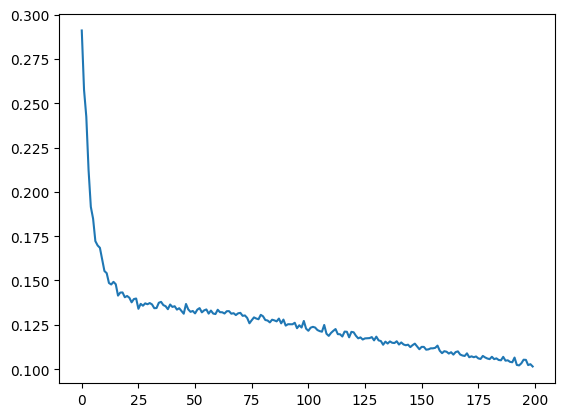

In [56]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(loss_log['up_end_mae'])), loss_log['up_end_mae'])
plt.show()

In [27]:
torch.save(up_changer.state_dict(), 'submission_files/moritz_deep6/model_new_scheduler_0.95_0.1_0.1_newact.pth')

In [5]:
# to generate test predictions
testloader = DataLoader(list(zip(lr_X_dim1_test, lr_X_dim3_test, lr_test)), shuffle=False, batch_size=16)

up_changer.eval()
test_predictions = []
for X_lr, Y_lr, adj_lr in tqdm(testloader):
    pred = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))[-1].detach()
    test_predictions.append(pred)
test_predictions = torch.cat(test_predictions)

NameError: name 'DataLoader' is not defined

In [29]:
torch.save(test_predictions, 'submission_files/moritz_deep6/model_new_scheduler_0.95_0.1_0.1_newact.pt')

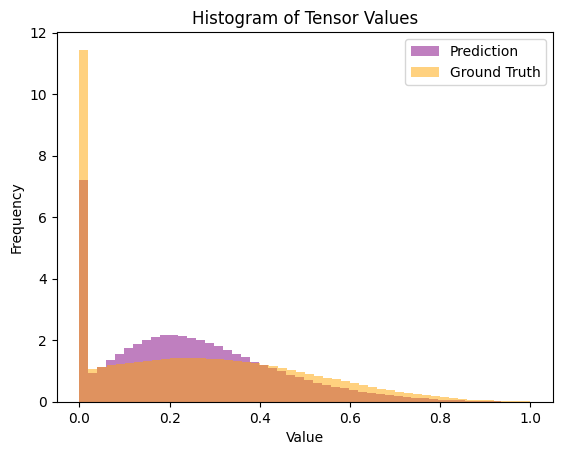

In [58]:
from data_preparation import generate_histogram
generate_histogram(test_predictions.cpu(), hr_train)

In [61]:
# to generate train predictions
new_trainloader = DataLoader(list(zip(lr_X_dim1, lr_X_dim3, lr_train)), shuffle=True, batch_size=16)

up_changer.eval()
train_predictions = []
for X_lr, Y_lr, adj_lr in tqdm(new_trainloader):
    pred = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))[-1].detach()
    train_predictions.append(pred)
train_predictions = torch.cat(train_predictions)

100%|██████████| 11/11 [00:01<00:00,  9.71it/s]


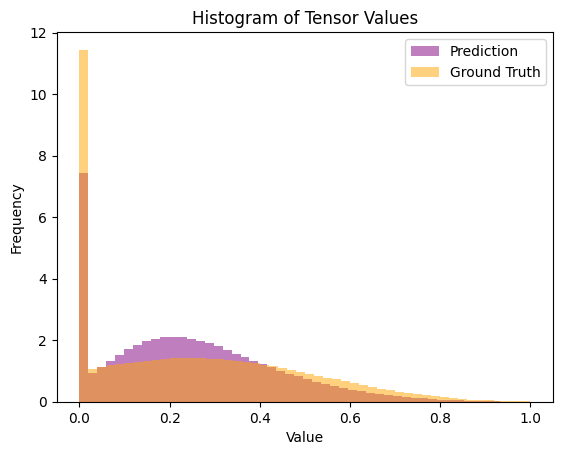

In [62]:
from data_preparation import generate_histogram
generate_histogram(train_predictions.cpu(), hr_train)

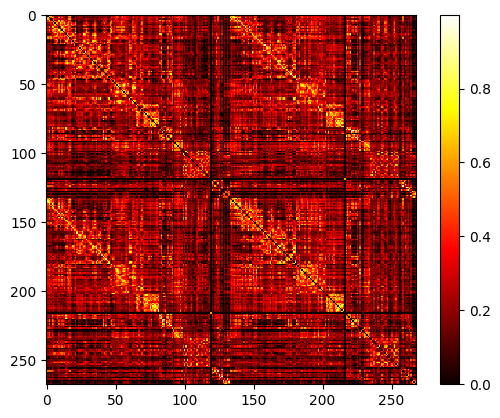

In [26]:
from data_preparation import generate_heatmap
generate_heatmap(test_predictions[0].cpu())

In [24]:
from data_preparation import generate_submission_file

df = generate_submission_file(test_predictions.cpu(), 'submission_files/moritz_deep6/new_scheduler_0.95_0.5_0.1_tanhrelu.csv')

# Cross Validation

In [39]:
from evaluation_fn import evaluate_predictions
from data_preparation import generate_histogram, generate_heatmap

def validation(up_changer, testloader, val_adj_hr, histogram=False, heatmap=False, statement=None):
    print('begin validation')
    up_changer.eval()

    val_predictions = []
    for X_lr, Y_lr, adj_lr in tqdm(testloader):
        pred = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))[-1].detach()
        val_predictions.append(pred)
    val_predictions = torch.cat(val_predictions)

    if histogram:
        if statement:
            print(statement)
        else:
            print(f'Histogram for Current Fold')
        generate_histogram(val_predictions.cpu(), val_adj_hr.cpu())
    if heatmap:
        if statement:
            print(statement)
        else:
            print(f'First Difference Heatmap for Current Fold')
        generate_heatmap((val_adj_hr[0].cpu() - val_predictions[0].cpu()))

    return {'eval': evaluate_predictions(val_predictions, val_adj_hr), 'preds': val_predictions}

In [40]:
def cross_validate(epochs, eval_step, batch_size, n_fold, X_lr, Y_lr, adj_lr, X_hr, Y_hr, adj_hr, num_steps, channels_ls = [32, 64], histogram=False, heatmap=False):
    kf = KFold(n_fold, shuffle=True, random_state=99)
    runs_results = []
    for train_idx, val_idx in kf.split(X_lr):
        train_X_lr, val_X_lr = X_lr[train_idx], X_lr[val_idx]
        train_Y_lr, val_Y_lr = Y_lr[train_idx], Y_lr[val_idx]
        train_adj_lr, val_adj_lr = adj_lr[train_idx], adj_lr[val_idx]
        train_X_hr = X_hr[train_idx]
        train_Y_hr = Y_hr[train_idx]
        train_adj_hr, val_adj_hr = adj_hr[train_idx], adj_hr[val_idx]

        trainloader = DataLoader(list(zip(train_X_lr, train_Y_lr, train_adj_lr, train_X_hr, train_Y_hr, train_adj_hr)), shuffle=False, batch_size=batch_size)

        dim_steps = generate_steps(num_steps=num_steps)
        channels_ls = [32, 64]
        embedding_dims_ls_up = [160,16,32]
        embedding_dims_ls_down = [268,16,32]

        up_changer = AdjacencyDimChanger(dim_steps, channels_ls, embedding_dims_ls_up).to(DEVICE)
        down_changer = AdjacencyDimChanger(dim_steps[::-1], channels_ls, embedding_dims_ls_down).to(DEVICE)

        up_optimizer = torch.optim.AdamW(up_changer.parameters(), lr=0.0025, betas=(0.5, 0.999))
        down_optimizer = torch.optim.AdamW(down_changer.parameters(), lr=0.0025, betas=(0.5, 0.999))
        reconstruction_optimizer = torch.optim.AdamW(list(up_changer.parameters()) + list(down_changer.parameters()), lr=0.0025, betas=(0.5, 0.999))
        
        losses = None
        completed = 0
        val_metrics = {}
        for i in range(0,epochs,eval_step):
            up_changer, down_changer, losses = train(eval_step, up_changer, down_changer, trainloader, up_optimizer, down_optimizer, reconstruction_optimizer, completed_epochs=completed, loss_log=losses)

            
            testloader = DataLoader(list(zip(val_X_lr, val_Y_lr, val_adj_lr)), shuffle=False, batch_size=batch_size)
            val_metrics[f'{i}'] = validation(up_changer, testloader, val_adj_hr, histogram, heatmap, statement=f'Currrent Fold after {i}')
            completed = i

        testloader = DataLoader(list(zip(val_X_lr, val_Y_lr, val_adj_lr)), shuffle=True, batch_size=batch_size)
        val_metrics[f'{epochs}'] = validation(up_changer, testloader, val_adj_hr, histogram, heatmap)
        val_metrics['losses'] = losses


        runs_results.append(val_metrics)

    return runs_results

ep 0: down loss = 0.19519715436867305, up loss = 0.17617509194782802, reconst.loss = 0.287555102791105, down adj mae = 0.2831381687096187, up adj mae = 0.29902770689555574
ep 5: down loss = 0.11665437689849309, up loss = 0.09248206445149013, reconst.loss = 0.2021049473966871, down adj mae = 0.22834016808441707, up adj mae = 0.20541547664574214
begin validation


100%|██████████| 4/4 [00:00<00:00,  9.17it/s]


Currrent Fold after 0


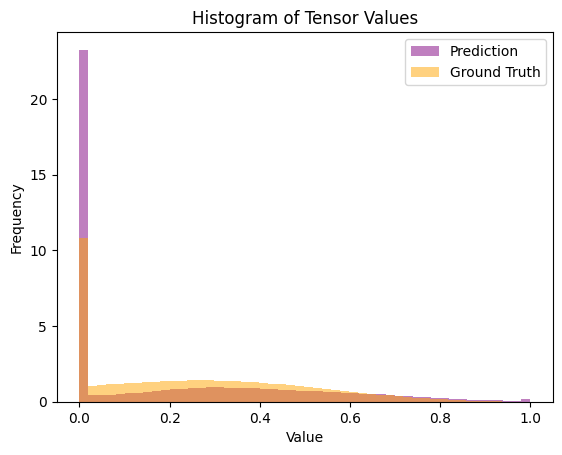

Evaluating Predictions (Can be Slow):  38%|███▊      | 21/56 [04:27<07:37, 13.07s/it]

In [41]:
import gc

#a=0.95

# del up_changer
# del down_changer
# del test_predictions
gc.collect()

torch.cuda.empty_cache()

results = cross_validate(200,10,16,3, lr_X_dim1, lr_X_dim3, lr_train, hr_X_dim1, hr_X_dim3, hr_train, num_steps=6, histogram=True, heatmap=False)

In [22]:
torch.save(results, 'submission_files/moritz_deep4/results_cv_0.95_0.5_0.002.pt')

[0.174918104495321, 0.14589284786156245, 0.13297852448054723, 0.1157514431646892, 0.11879795576844897, 0.09736089089087077, 0.09180118249995368, 0.07724575911249433, 0.07172081300190516, 0.06377226699675832, 0.06226235681346485, 0.05623753368854523, 0.05499196265425001, 0.049235813851867406, 0.04681469979030745, 0.047092964074441364, 0.04726385910596166, 0.04551862818854196, 0.04462029252733503, 0.044704081756728034, 0.041797696479729245, 0.04611229630453246, 0.04122467126165118, 0.03694302908011845, 0.038037094686712535, 0.038510719048125405, 0.036916004227740426, 0.034729884671313424, 0.03297500471983637, 0.03236655651458672, 0.030656782111951282, 0.03342040787850108, 0.03392957363809858, 0.034473877134067674, 0.031896590920431275, 0.02974186385316508, 0.03049686098737376, 0.029269389808177948, 0.029803482283438956, 0.031253284375582426, 0.030472446765218462, 0.030452542273061618, 0.02947984396346978, 0.030058702720063075, 0.030580019312245504, 0.02869851514697075, 0.0283137179378952

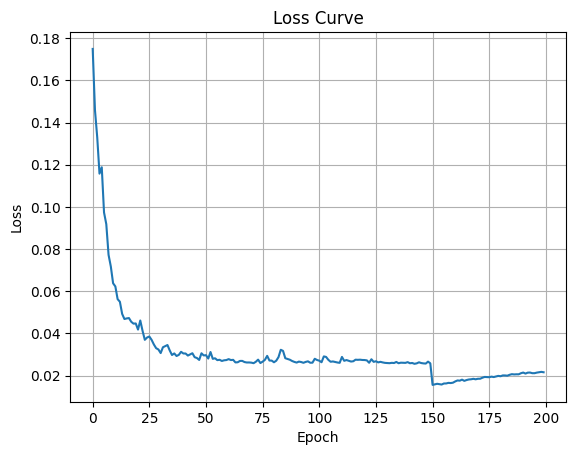

In [21]:
import matplotlib.pyplot as plt

losses_fold1 = results[2]['losses']['up']

print(losses_fold1)

plt.plot(losses_fold1)
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()
